# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.display import display

# 1. Загрузка и подготовка данных

In [2]:
# df1 = pd.read_csv('datasets/geo_data_0.csv')
# df2 = pd.read_csv('datasets/geo_data_1.csv')
# df3 = pd.read_csv('datasets/geo_data_2.csv')
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [3]:
def print_info(df):
    
    display(df.sample())
    display(df.describe().T)
    print('Количеству дубликатов:', df.duplicated().sum())

In [4]:
# Первый регион
print_info(df1)

,id,f0,f1,f2,product
29100,cmnla,-0.75231,0.568515,-0.466213,86.061167


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Количеству дубликатов: 0


In [5]:
# Второй регион
print_info(df2)

,id,f0,f1,f2,product
31683,qUSwb,-12.22628,-4.317265,1.005109,30.132364


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Количеству дубликатов: 0


In [6]:
# Третий регион
print_info(df3)

,id,f0,f1,f2,product
60718,SAvCp,1.573395,4.399913,3.770045,113.193558


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Количеству дубликатов: 0


Дисперсия целевового признака во всех регионах примерно одинаковая, но среднее во втором регионе несколько ниже, чем у двух других.

Дубликатов и пропусков в данных нет, их можно отправлять в модель, но сначала посмотрим на распределения и зависимости целевого признака.

Воспользуемся библиотекой seaborn, чтобы отобразить графики рядом, сохраним их поотдельности и склеим как изображения (jointplot возвращает не привычный AxesSubplot, а JointGrid, и соединить несколько с помощью subplots нельзя).

In [7]:
def plot_jointplots(df, figsize=(15, 5)):
    
    g1 = sns.jointplot(data=df, x="f0", y="product", kind="hex")
    g2 = sns.jointplot(data=df, x="f1", y="product", kind="hex")
    g3 = sns.jointplot(data=df, x="f2", y="product", kind="hex")

    # SAVE PLOTS IN MEMORY TEMPORALLY
    g1.savefig('g1.png')
    plt.close(g1.fig)

    g2.savefig('g2.png')
    plt.close(g2.fig)

    g3.savefig('g3.png')
    plt.close(g3.fig)

    # CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
    figure, axs = plt.subplots(1, 3, figsize=figsize)
    
    axs[0].imshow(mpimg.imread('g1.png'))
    axs[1].imshow(mpimg.imread('g2.png'))
    axs[2].imshow(mpimg.imread('g3.png'))

    # turn off x and y axis
    [ax.set_axis_off() for ax in axs]

    plt.tight_layout()
    plt.show()

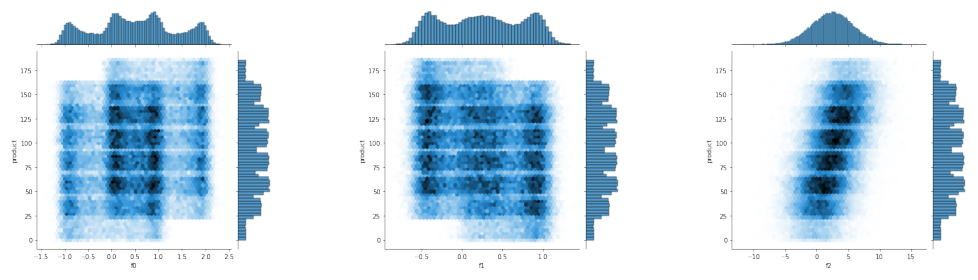

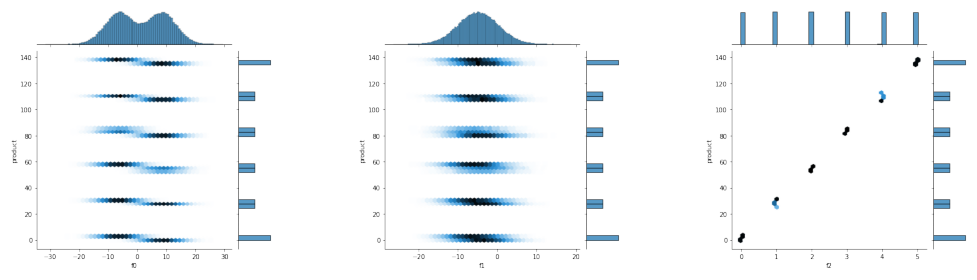

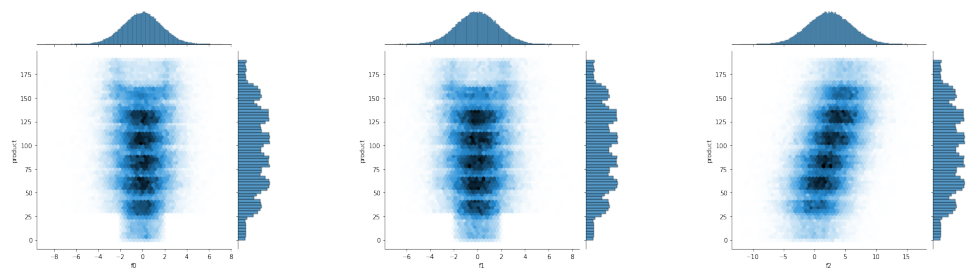

In [8]:
# Первый регион
plot_jointplots(df1, figsize=(15,4))

# Второй регион
plot_jointplots(df2, figsize=(15,4))

# Третий регион
plot_jointplots(df3, figsize=(15,4))

Сразу можно сказать, что линейная регрессия хорошо отработает на только на третьем признаке.

В первом регионе первый и второй признаки имеют множество пиков в распределении, возможно, стоит разбить данные на несколько диапазонов.

Во втором регионе целевая переменная имеет дискретное распределение, что кажется странным. Первый признак имеет два пика в расперделении.

# 2. Обучение и проверка модели

Обучим модель машинного обучения и предскажем запасы сырья для каждого из регионов. Для этого сначала разобьем наши данные на тренировочную
и влидационную выборки 3:1, далее обучим линейную регрессию и посчитаем средний запас сырья, в качестве метрики используем среднеквадратичное отклонение.

In [9]:
def predict_product(df, region_number):
    
    X = df[['f0', 'f1', 'f2']]
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, prediction)**0.5
    
    print(f'Средний предсказанный запас сырья региона №{region_number}:', prediction.mean().round(2), 'тыс. баррелей.')
    print(f'Среднеквардратичное отклонение модели для региона №{region_number}:', rmse.round(2), 'тыс. баррелей.')
    
    return pd.Series(prediction), pd.Series(y_valid)

In [10]:
# Первый регион
prediction_1, true_1 = predict_product(df1, 1)
true_1.index = prediction_1.index #new
print()

# Второй регион
prediction_2, true_2 = predict_product(df2, 2);
true_2.index = prediction_2.index #new
print()

# Третий регион
prediction_3, true_3 = predict_product(df3, 3);
true_3.index = prediction_3.index #new

Средний предсказанный запас сырья региона №1: 92.4 тыс. баррелей.
Среднеквардратичное отклонение модели для региона №1: 37.76 тыс. баррелей.

Средний предсказанный запас сырья региона №2: 68.71 тыс. баррелей.
Среднеквардратичное отклонение модели для региона №2: 0.89 тыс. баррелей.

Средний предсказанный запас сырья региона №3: 94.77 тыс. баррелей.
Среднеквардратичное отклонение модели для региона №3: 40.15 тыс. баррелей.


Видим, что предсказанные запасы первого и третьего регионов очень похожи друг на друга - чуть больше 90 тыс. баррелей на скважину, и СКО 40 тыс. баррелей. У второго региона средний предсказанный запас меньше - 68 тыс. баррелей, но и достаточно маленькое отклонение - 0.9 тыс. баррелей.

# 3. Подготовка к расчёту прибыли

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- бюджет на разработку скважин в регионе — 10 млрд рублей;
- при нынешних ценах один баррель сырья приносит 450 рублей дохода.

Посчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [11]:
BUDGET = 10**10
BARREL_PRICE = 450000 # Цена за тысячу баррелей
BOREHOLES_NUMBER = 200
min_volume = BUDGET / (BARREL_PRICE*BOREHOLES_NUMBER)
print('Достаточный средний объем скважин:', np.round(min_volume, 2), 'тыс. баррелей.')

Достаточный средний объем скважин: 111.11 тыс. баррелей.


Достаточный средний объем скважин больше, чем средние запасы в каждом регионе. Но, нам нужны только 200 скважин, поэтому выберем скважины с самым большим объемом.

Напишем функция для расчета прибыли. Она возьмет 500 случайных месторожодений в каждом регионе и выберет из них 200 лучших для разработки, затем оценит прибыль или убыток. 

In [12]:
def calculate_revenue(prediction, true):
   
    predicted_boreholes = prediction.sort_values(ascending=False)
    best_predicted_boreholes = predicted_boreholes[:200]
    best_true_boreholes = true[best_predicted_boreholes.index]
    
    
    boreholes_volume = best_true_boreholes.sum()
    revenue = boreholes_volume * BARREL_PRICE - BUDGET
    
    return revenue

# 4. Расчёт прибыли и рисков 

Применим технику бутстреп - повторим расчет прибыли 1000 раз и построим графики распределений.

In [13]:
revenue_1 = []
revenue_2 = []
revenue_3 = []
state = np.random.RandomState(42)

for i in range(1000):
    
    boreholes_1 = prediction_1.sample(500, replace=True, random_state=state)
    revenue_1.append(calculate_revenue(boreholes_1, true_1))
    
    boreholes_2 = prediction_2.sample(500, replace=True, random_state=state)
    revenue_2.append(calculate_revenue(boreholes_2, true_2))
    
    boreholes_3 = prediction_3.sample(500, replace=True, random_state=state)
    revenue_3.append(calculate_revenue(boreholes_3, true_3))
    
revenue_1 = pd.Series(revenue_1)
revenue_2 = pd.Series(revenue_2)
revenue_3 = pd.Series(revenue_3)

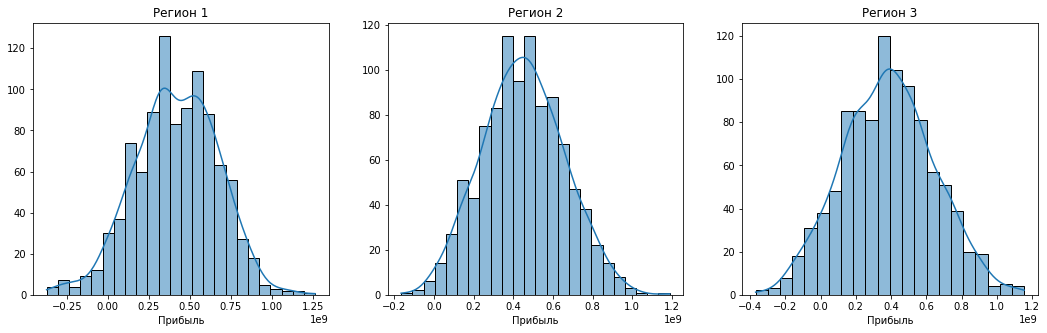

In [14]:
figure, axs = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(revenue_1, ax=axs[0], kde=True)
sns.histplot(revenue_2, ax=axs[1], kde=True)
sns.histplot(revenue_3, ax=axs[2], kde=True)

axs[0].set_title('Регион 1')
axs[1].set_title('Регион 2')
axs[2].set_title('Регион 3')

axs[0].set_xlabel('Прибыль')
axs[1].set_xlabel('Прибыль')
axs[2].set_xlabel('Прибыль')

axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('');

In [15]:
print('Средняя прибыль с месторождений первого региона:', np.round(revenue_1.mean()/10**6,2), 'млн. руб.')
print('Нижняя граница прибыли с месторождений первого региона:', np.round(revenue_1.quantile(0.025)/10**6,2), 'млн. руб.')
print('Верхняя граница прибыли с месторождений первого региона:', np.round(revenue_1.quantile(0.975)/10**6,2), 'млн. руб.') #new
print('Вероятность убытка с месторождений первого региона:', stats.percentileofscore(revenue_1, 0), '%')
print()

print('Средняя прибыль с месторождений второго региона:', np.round(revenue_2.mean()/10**6,2), 'млн. руб.')
print('Нижняя граница прибыли с месторождений второго региона:', np.round(revenue_2.quantile(0.025)/10**6,2), 'млн. руб.')
print('Верхняя граница прибыли с месторождений второго региона:', np.round(revenue_2.quantile(0.975)/10**6,2), 'млн. руб.') #new
print('Вероятность убытка с месторождений второго региона:', stats.percentileofscore(revenue_2, 0), '%')
print()

print('Средняя прибыль с месторождений третьего региона:', np.round(revenue_3.mean()/10**6,2), 'млн. руб.')
print('Нижняя граница прибыли с месторождений третьего региона:', np.round(revenue_3.quantile(0.025)/10**6,2), 'млн. руб.')
print('Верхняя граница прибыли с месторождений третьего региона:', np.round(revenue_3.quantile(0.975)/10**6,2), 'млн. руб.') #new
print('Вероятность убытка с месторождений третьего региона:', stats.percentileofscore(revenue_3, 0), '%')
print()

Средняя прибыль с месторождений первого региона: 416.34 млн. руб.
Нижняя граница прибыли с месторождений первого региона: -83.27 млн. руб.
Верхняя граница прибыли с месторождений первого региона: 868.69 млн. руб.
Вероятность убытка с месторождений первого региона: 5.1 %

Средняя прибыль с месторождений второго региона: 449.67 млн. руб.
Нижняя граница прибыли с месторождений второго региона: 67.46 млн. руб.
Верхняя граница прибыли с месторождений второго региона: 853.7 млн. руб.
Вероятность убытка с месторождений второго региона: 0.8 %

Средняя прибыль с месторождений третьего региона: 384.34 млн. руб.
Нижняя граница прибыли с месторождений третьего региона: -125.17 млн. руб.
Верхняя граница прибыли с месторождений третьего региона: 894.3 млн. руб.
Вероятность убытка с месторождений третьего региона: 7.1 %



В среднем все регионы оказались прибыльными. Однако только второй регион соответствует нашим рискам, у него же и самая высокая средняя прибыль.

**Для разработки месторождений рекомендуем выбрать второй регион**, он имеет приемлемые риски - вероятность убытка 0.8%, и наибольшую среднюю прибыль - 449.67 млн. руб, а так же модель линейной регрессии лучше всего отработала именно на этом регионе.

# Вывод

В данной работе проведен анализ прибыльности нефтянных месторождений трех регионов:
- загружены и обработанны данные месторождений;
- обучена линейная модель и предсказаны запасы сырья;
- написана функция для расчета прибыли;
- посчитаны средние прибыли с регионов и оценены риски.

Для разработки рекомендован второй регион.